# **Introducción**



El objetivo de este proyecto es predecir por medio aprendizaje de máquina o más comunmente llamado machine learning aplicado a las distintas variables referidas al clima, cuyos datos se pudieron recolectar en el último año dada una ubicación geográfica expresada en latitud y longitud

Se buscó predecir las condiciones climáticas del año 2024 basados en los  datos de OpenWeather del mismo año, en lo que va del año en Santiago del Estero. Los datos son proporcionados por una API de OpenWeather, cuya función para obtener datos se requiere las coordenadas geográficas. Las coordenadas expresadas en decimales de Santiago del Estero son: *Latitud: -27.784444, Longitud: -64.266944*

Para recopilar los datos usé la API de datos estadísticos de una web llamada ***OpenWeather***, la cual ofrece un servicio de datos históricos del clima.

Para la representación de las gráficas usé las librerías ***Matplotlib*** y ***Seaborn***.

Para los modelos de machine learning se usó la librería ***scikit-learn*** y todos sus componentes.

Para comunicarme con la API usé la librería ***requests***.

Y finalmente para manejar los datos usé ***Pandas***, librería dedicada al análisis de datos.

**Librerías necesarias:**

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import userdata

API_key = userdata.get("API_key")

# **Primera parte: Extracción de los datos de la API**
Para poder trabajar con los datos primero se debe extraerlos, para ello definimos la siguiente función que solo necesita la latitud y la longitud de una ubicación geográfica expresadas en decimales.

Si el servidor no tiene problemas a la hora de contactarlo, se otorgarán los datos en formato JSON listos para ser procesados, en caso contrario se enviará un mensaje de error con la razón.

In [ ]:
def extraer_datos_historicos(latitud, longitud):
    url = f"https://history.openweathermap.org/data/2.5/aggregated/year?lat={latitud}&lon={longitud}&appid={API_key}"

    respuesta = requests.get(url)

    if respuesta.status_code == 200:
        return respuesta.json()
    else:
        print(f"Error al obtener datos: {respuesta.status_code}")
        return None

# **Segunda parte: Procesamiento y limpieza de los datos**
La mejor forma de organizar los datos a menudo suelen ser las tablas, donde las filas suelen indicar los índices y las columnas el nombre de la variable, para ello pandas ofrece los dataframe, los cuales son tablas con este mismo formato.

Una vez obtenidos los datos de manera satisfactoria pandas ofrece una función para transformar el JSON a dataframe de la propia pandas para una correcta organización y así además normalizar los datos para el análisis.

In [ ]:
def transformar_datos(latitud, longitud):
    datos_historicos = extraer_datos_historicos(latitud, longitud)

    #Crear el dataframe
    if datos_historicos and "result" in datos_historicos:
        df = pd.json_normalize(datos_historicos["result"])
        return df
    else:
        print("Error: Datos no válidos")
        return None

    #Formateo, en este caso no hará falta dado que los datos que vienen de la API ya estan prelimpiados.
    '''df.drop_duplicates(inplace=True)
    df.fillna(method= "ffill", inplace=True)'''

Una vez definida la función para transformar los datos, podemos observar como estos se ven:

In [ ]:
latitud = -27.784444
longitud = -64.266944
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
df_historicos = transformar_datos(latitud,longitud)
print(df_historicos.head())

   month  day  temp.record_min  ...  clouds.p75  clouds.st_dev  clouds.num
0      1    1           291.48  ...        66.5          36.55         288
1      1    2           291.00  ...        56.0          34.87         288
2      1    3           289.06  ...        43.5          35.94         288
3      1    4           290.80  ...        28.0          34.75         288
4      1    5           293.85  ...        80.0          38.95         288

[5 rows x 52 columns]


In [ ]:
print(df_historicos.loc[df_historicos["month"] == 2])

    month  day  temp.record_min  ...  clouds.p75  clouds.st_dev  clouds.num
31      2    1           291.42  ...        69.0          36.02         288
32      2    2           291.80  ...        76.0          38.36         288
33      2    3           290.86  ...        59.5          32.60         288
34      2    4           288.94  ...        69.5          35.57         288
35      2    5           290.38  ...        72.0          34.92         288
..    ...  ...              ...  ...         ...            ...         ...
55      2   25           289.50  ...        92.0          35.85         288
56      2   26           287.82  ...        90.5          35.89         288
57      2   27           286.28  ...        80.5          38.99         288
58      2   28           289.35  ...        88.0          41.68         288
59      2   29           293.16  ...        81.0          39.28          72

[29 rows x 52 columns]


# **Tercera parte: Entrenamiento y elección de modelos para Machine Learning**


### **Elección de variables objetivo y variables predictoras**
Como se quiere predecir las variables climáticas de lo que queda del año, considero que las variables más importantes para predecir, es decir el las **variables objetivo** son el promedio de las siguientes:


*   **Precipitaciones:** Porque la media de precipitaciones nos servirá para observar durante las fechas como va creciendo o decreciendo la cantidad de lluvia en los días y para observar si hay alguna predicción de anomalía o desastre como inundaciones, ciclones o huracanes.
*   **Temperatura:** La media de temperaturas es muy útil a la hora de ver tendencias y observar la estacionalidad
*   **Humedad:** La media de humedad con el pasar de los días es muy importante dado que tiene correlación con las otras dos variables, para saber que tan agradable es un clima hace falta saber la humedad, y la media de la humedad nos proporciona una buena medida dado que si el aire es demasiado húmedo, existe el riesgo de que se forme moho.
*   **Velocidad del viento:** El viento actúa como agente de transporte, en efecto, interviene en la polinización anemófila, en el desplazamiento de las semillas. Es también un poderoso agente erosivo, en especial en las zonas de clima seco o desértico, donde los granos de arena arrastrados por el viento pueden llegar a la transformación y hasta la denudación (es decir, la completa remoción) de las formas del relieve. También actúa como agente de sedimentación, ya que cuando el viento pierde velocidad, deposita los materiales que transporta. Por lo que saber la media de la velocidad del viento es muy importante para muchas areas.

Todas las otras variables no funcionan como **variables predictoras**, esto es así para que se pueda predecir mediante correlaciones el valor del siguiente día, y así sucesivamente. Además de que muchos datos presentan correlación con el tiempo debido a la estacionalidad.

Para realizar el entrenamiento del modelo de regresión se dividen los datos en dos grandes conjuntos, el de pruebas y el conjunto de datos de entrenamiento. El conjunto de pruebas es necesario para evaluar el rendimiento del modelo elegido.

In [ ]:
from sklearn.model_selection import train_test_split

print(df_historicos.head())

#Variable objetivo
target_precipitation = "precipitation.mean"
target_temp = "temp.mean"
target_humidity = "humidity.mean"
target_wind = "wind.mean"

#Variables predictoras
predict_precipitation = df_historicos.columns.difference([target_precipitation, "day", "month"])
predict_temp = df_historicos.columns.difference([target_temp, "day", "month"])
predict_humidity = df_historicos.columns.difference([target_humidity, "day", "month"])
predict_wind = df_historicos.columns.difference([target_wind, "day", "month"])

X_precipitation = df_historicos[predict_precipitation]
X_temperature = df_historicos[predict_temp]
X_humidity = df_historicos[predict_humidity]
X_wind = df_historicos[predict_wind]
y_precipitation = df_historicos[target_precipitation]
y_temperature = df_historicos[target_temp]
y_humidity = df_historicos[target_humidity]
y_wind = df_historicos[target_wind]

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_precipitation, y_precipitation, test_size=0.2, random_state=42)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_temperature, y_temperature, test_size=0.2, random_state=42)
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_humidity, y_humidity, test_size=0.2, random_state=42)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wind, y_wind, test_size=0.2, random_state=42)

   month  day  temp.record_min  ...  clouds.p75  clouds.st_dev  clouds.num
0      1    1           291.48  ...        66.5          36.55         288
1      1    2           291.00  ...        56.0          34.87         288
2      1    3           289.06  ...        43.5          35.94         288
3      1    4           290.80  ...        28.0          34.75         288
4      1    5           293.85  ...        80.0          38.95         288

[5 rows x 52 columns]


### **Setup de los modelos**

El proceso de establecer y elegir los modelos se da en base al problema, en este caso particular se usaron **cuatro modelos de regresión**.

In [ ]:
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

modelos = {
  "Regresión Lineal": LinearRegression(),
  "Potenciación de Gradiente": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
  "Regresión Polinómica de grado 2": make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
  "Regresión de Poisson": PoissonRegressor(max_iter=6000)
}

Los modelos de regresión son modelos matemáticos que buscan determinar y evaluar la relación entre una variable dependiente (Y), con respecto a otras variables, llamadas explicativas o independientes (X).

No todos se pueden aplicar de cualquier manera a cualquier variable, por ejemplo el modelo de regresión lineal no se puede aplicar cuando mi variable de interés es una variable categórica. Como en este caso como se intenta predecir la media de las precipitaciones, temperatura, humedad y viento se observarán cuales regresiones son las mejores para cada una.

### **Métricas para la evaluación del modelo predictivo para precipitaciones, temperatura, humedad y viento**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

resultados_precipitaciones = {}
resultados_temperatura = {}
resultados_humedad = {}
resultados_viento = {}

def entrenar_y_evaluar(model, X_train, y_train, X_test, y_test, resultados, name):
    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    # Guardar resultados
    resultados[name] = {
        "MSE": mse,
        "MAE": mae,
        "R²": r2,
        "RMSE": rmse,
    }

for name, model in modelos.items():
    entrenar_y_evaluar(model, X_train_p, y_train_p, X_test_p, y_test_p, resultados_precipitaciones, name)
    entrenar_y_evaluar(model, X_train_t, y_train_t, X_test_t, y_test_t, resultados_temperatura, name)
    entrenar_y_evaluar(model, X_train_h, y_train_h, X_test_h, y_test_h, resultados_humedad, name)
    entrenar_y_evaluar(model, X_train_w, y_train_w, X_test_w, y_test_w, resultados_viento, name)

# Mostrar los resultados
print("Resultados de las métricas de los modelos con objeto en la media de las precipitaciones")
print(pd.DataFrame(resultados_precipitaciones).T)
print("\n\nResultados de las métricas de los modelos con objeto en la media de las temperaturas")
print(pd.DataFrame(resultados_temperatura).T)
print("\n\nResultados de las métricas de los modelos con objeto en la media de la humedad")
print(pd.DataFrame(resultados_humedad).T)
print("\n\nResultados de las métricas de los modelos con objeto en la media de la velocidad del viento")
print(pd.DataFrame(resultados_viento).T)

Resultados de las métricas de los modelos con objeto en la media de las precipitaciones
                                      MSE       MAE        R²      RMSE
Regresión Lineal                 0.000863  0.017023  0.921863  0.029377
Potenciación de Gradiente        0.002955  0.018638  0.732424  0.054362
Regresión Polinómica de grado 2  0.006809  0.059660  0.383494  0.082516
Regresión de Poisson             0.005545  0.042663  0.497936  0.074465


Resultados de las métricas de los modelos con objeto en la media de las temperaturas
                                      MSE       MAE        R²      RMSE
Regresión Lineal                 0.023361  0.127526  0.998981  0.152842
Potenciación de Gradiente        0.085394  0.241535  0.996274  0.292222
Regresión Polinómica de grado 2  0.235239  0.347552  0.989736  0.485015
Regresión de Poisson             0.190524  0.348215  0.991687  0.436490


Resultados de las métricas de los modelos con objeto en la media de la humedad
                        

Las métricas **MAE, MSE, RMSE y R2** son medidas de evaluación utilizadas en el análisis de datos y en la estadística para medir el rendimiento de modelos de regresión y pronóstico.

- MAE (Mean Absolute Error): es la media aritmética de las diferencias absolutas entre las predicciones y los valores reales. Esta métrica indica el tamaño promedio de los errores en las predicciones del modelo y se expresa en las mismas unidades que la variable de interés.

- MSE (Mean Squared Error): es la media aritmética de los errores al cuadrado entre las predicciones y los valores reales. Esta métrica penaliza los errores grandes y se expresa en unidades cuadradas de la variable de interés.

- RMSE (Root Mean Squared Error): es la raíz cuadrada de Mse y se utiliza para obtener una medida de error en las mismas unidades que la variable de interés. Esta métrica indica la desviación estándar de los errores del modelo.

- R2 (Coeficiente de determinación): es una medida de ajuste del modelo que indica la proporción de la varianza total de la variable de interés que se explica por el modelo. R2 varía entre 0 y 1, y cuanto más cerca está de 1, mejor es el ajuste del modelo.

Estas métricas son herramientas útiles para evaluar el desempeño de un modelo de regresión o pronóstico y son utilizadas para seleccionar el modelo que mejor se ajuste a los datos, para hacer ajustes en el modelo y para comparar diferentes modelos.

## **Gráficas de pérdidas en el entrenamiento y en las pruebas**

Todas estas gráficas se usan para representar primero, que al hacer el entrenamiento y posterior validación de un modelo, hay datos que se pierden, además en la validación se puede observar el grado de precisión del entrenamiento, y finalmente se puede observar los errores o residuos de los modelos aplicadas en cada variable de interés.


### **Colores y librerías para las gráficas**

In [ ]:
from sklearn.metrics import PredictionErrorDisplay

colores_precipitation = [
["royalblue","slateblue"],
["darkblue","purple"]]

colores_temperature = [
["red","orange"],
["yellow","khaki"]]

colores_humidity = [
["darkslategray","cyan"],
["teal","paleturquoise"]]

colores_wind = [
["green","darkgreen"],
["lime","limegreen"]]

### **Funciones para generar gráficas**

In [ ]:
def grafica_perdidas(X_train, X_test, y_train, y_test, colores):
    fig, ax1 = plt.subplots(nrows=2 , ncols=2 , figsize=(10, 8))
    i = 0
    j = 0
    for name, model in modelos.items():
      # Entrenar el modelo
      model.fit(X_train, y_train)
      display = PredictionErrorDisplay.from_estimator(model, X_train, y_train, ax = ax1[i,j], scatter_kwargs={'color': colores[i][j]})
      ax1[i,j].set_title(name)

      i += 1
      if i == 2:
          i = 0
          j += 1

    plt.tight_layout()
    plt.show()

def grafica_precision(X_train, X_test, y_train, y_test, colores):
    fig, ax = plt.subplots(nrows=2 , ncols=2 , figsize=(10, 8))
    i = 0
    j = 0

    for name, model in modelos.items():
        # Entrenamiento del modelo y posterior predicción
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        ax[i,j].scatter(y_test, y_pred, color=colores[i][j], alpha=0.6, edgecolors='w', s=50)
        ax[i,j].plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=2)
        ax[i,j].set_xlabel("Valores reales")
        ax[i,j].set_ylabel("Valores predichos")
        ax[i,j].set_title(name)

        i += 1
        if i == 2:
            i = 0
            j += 1

    plt.tight_layout()
    plt.show()

def grafica_residuos(X_train, X_test, y_train, y_test, colores):
    fig, ax = plt.subplots(nrows=2 , ncols=2 , figsize=(10, 8))
    i = 0
    j = 0

    for name, model in modelos.items():
        # Entrenamiento del modelo y posterior predicción
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        ax[i,j].scatter(y_test, y_test - y_pred, color=colores[i][j], alpha=0.6, edgecolors='w', s=50)
        ax[i,j].hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors="black", linestyles='dashed')
        ax[i,j].set_xlabel("Valores reales")
        ax[i,j].set_ylabel("Valores predichos")
        ax[i,j].set_title(name)

        i += 1
        if i == 2:
            i = 0
            j += 1

    plt.tight_layout()
    plt.show()

### **Gráficas del ratio de pérdidas en los entrenamientos de los modelos**

#### **Pérdidas en el cálculo de las precipitaciones**

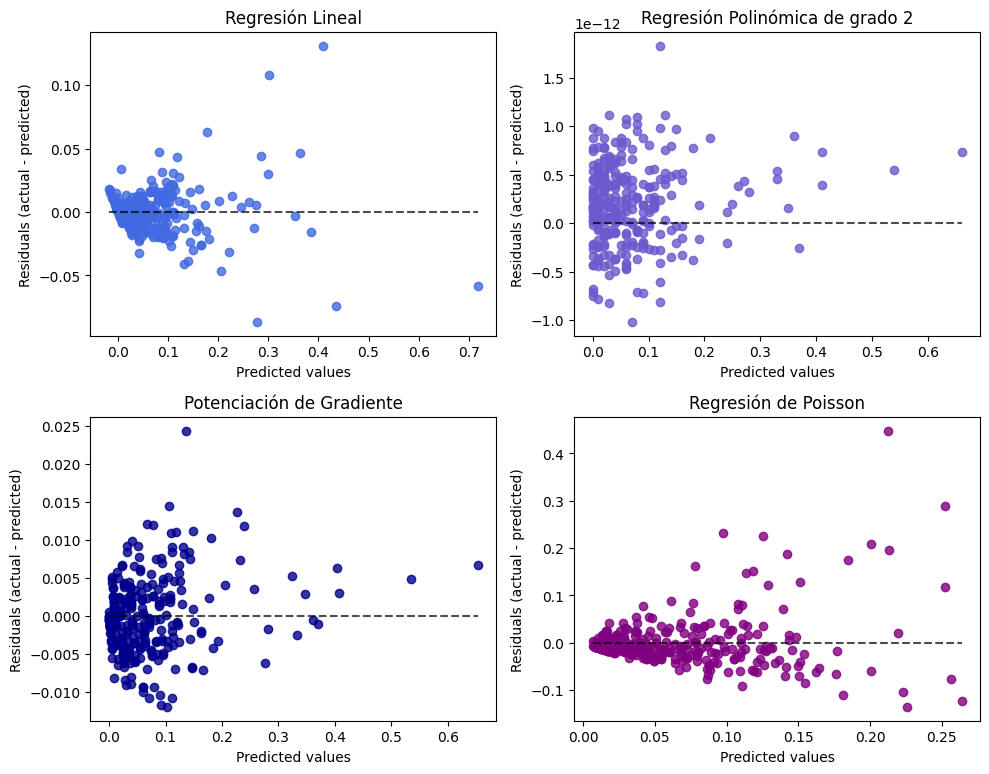

In [ ]:
grafica_perdidas(X_train_p, X_test_p, y_train_p, y_test_p, colores_precipitation)

#### **Pérdidas en el cálculo de las temperaturas**

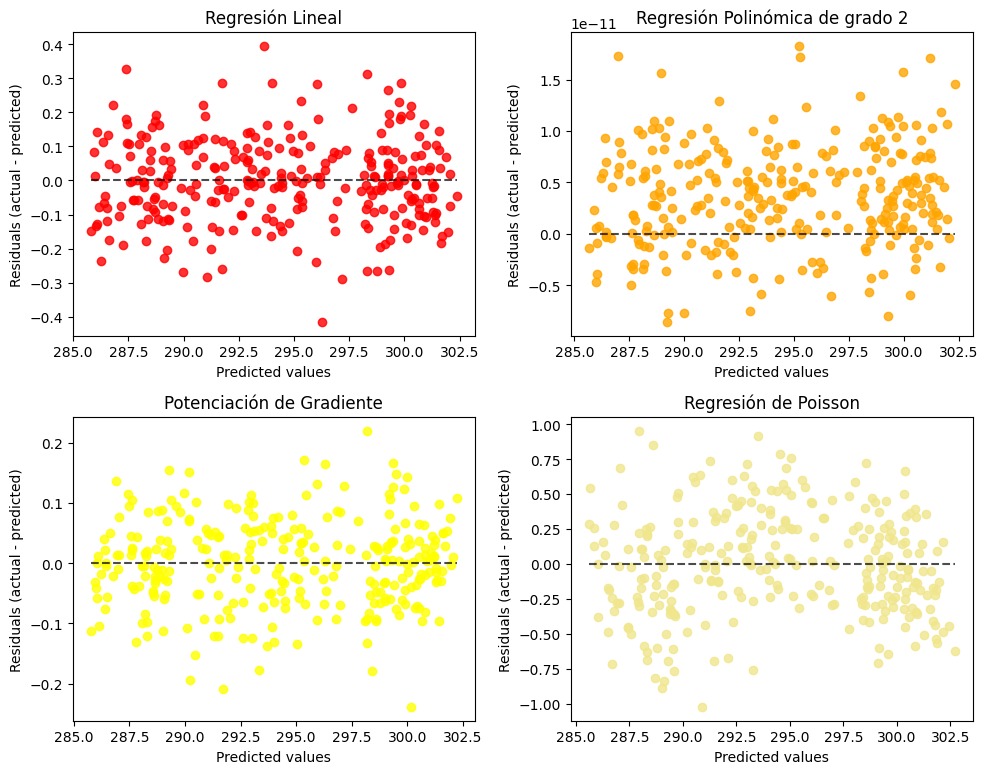

In [ ]:
grafica_perdidas(X_train_t, X_test_t, y_train_t, y_test_t, colores_temperature)

#### **Pérdidas en el cálculo de la humedad**

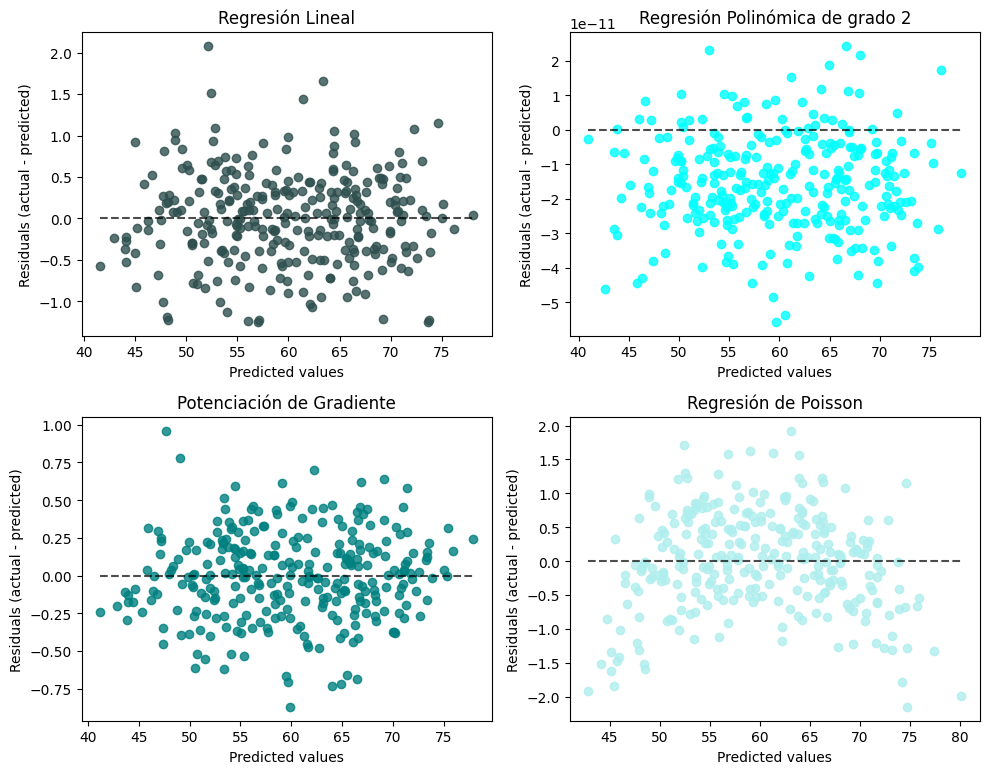

In [ ]:
grafica_perdidas(X_train_h, X_test_h, y_train_h, y_test_h, colores_humidity)

#### **Perdidas en el cálculo del viento**

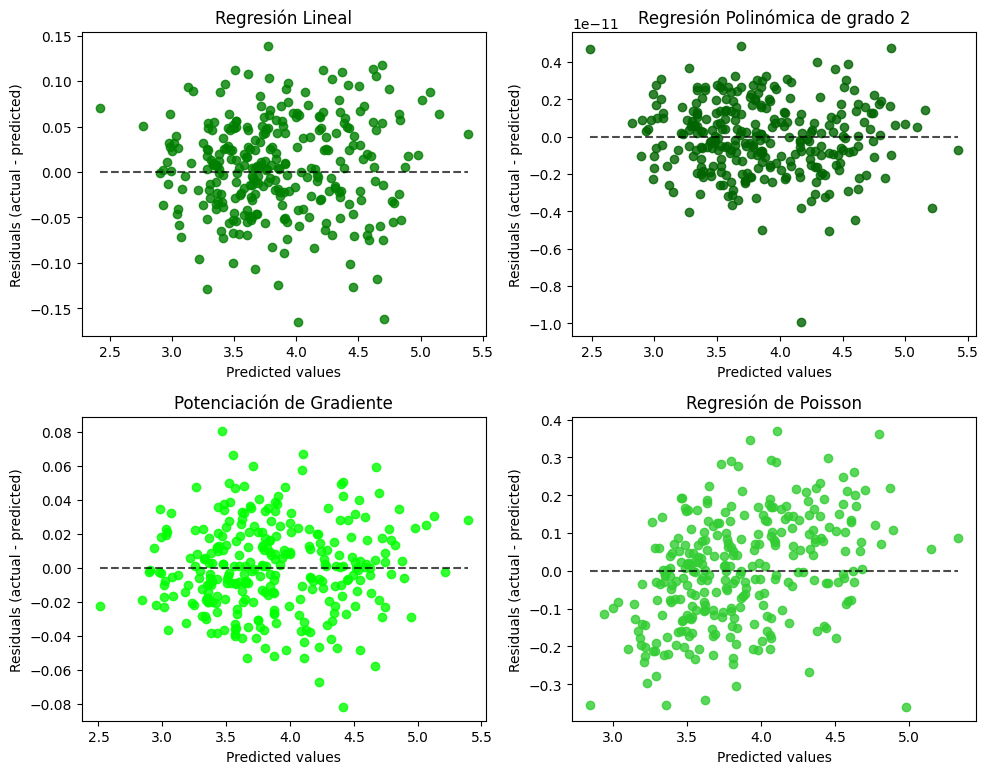

In [ ]:
grafica_perdidas(X_train_w, X_test_w, y_train_w, y_test_w, colores_wind)

### **Gráficas de la precisión del entrenamiento de los modelos en relación con las variables de validación**

#### **Precisión del cálculo de las precipitaciones**

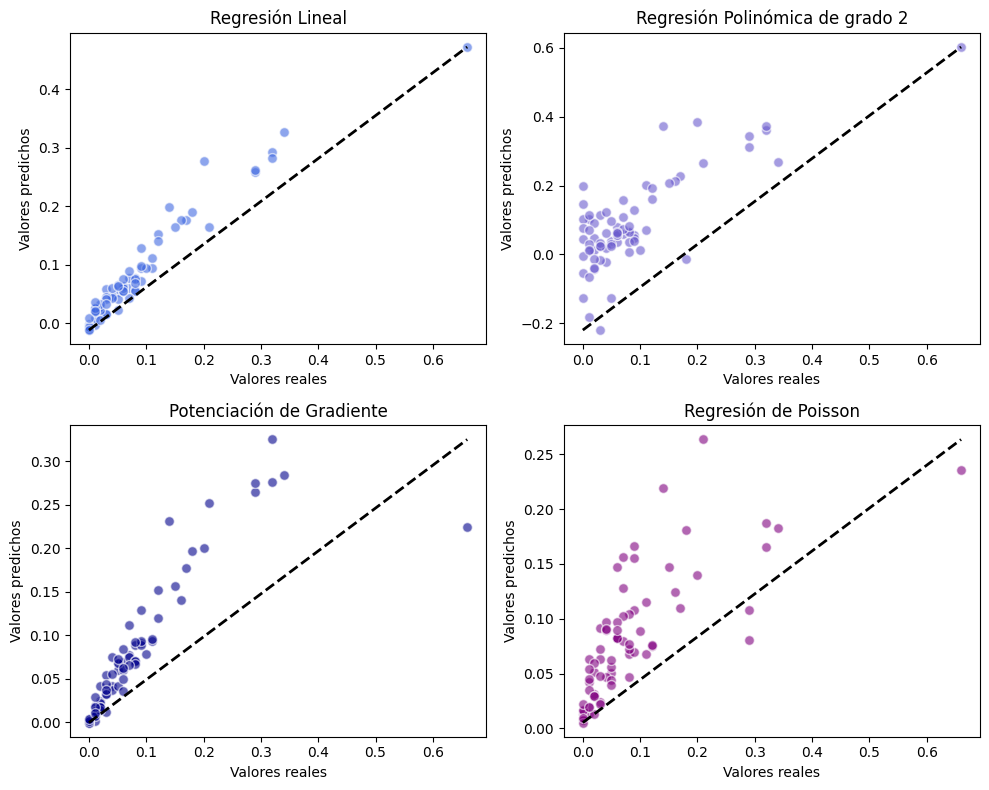

In [ ]:
grafica_precision(X_train_p, X_test_p, y_train_p, y_test_p, colores_precipitation)

#### **Precisión del cálculo de las temperaturas**

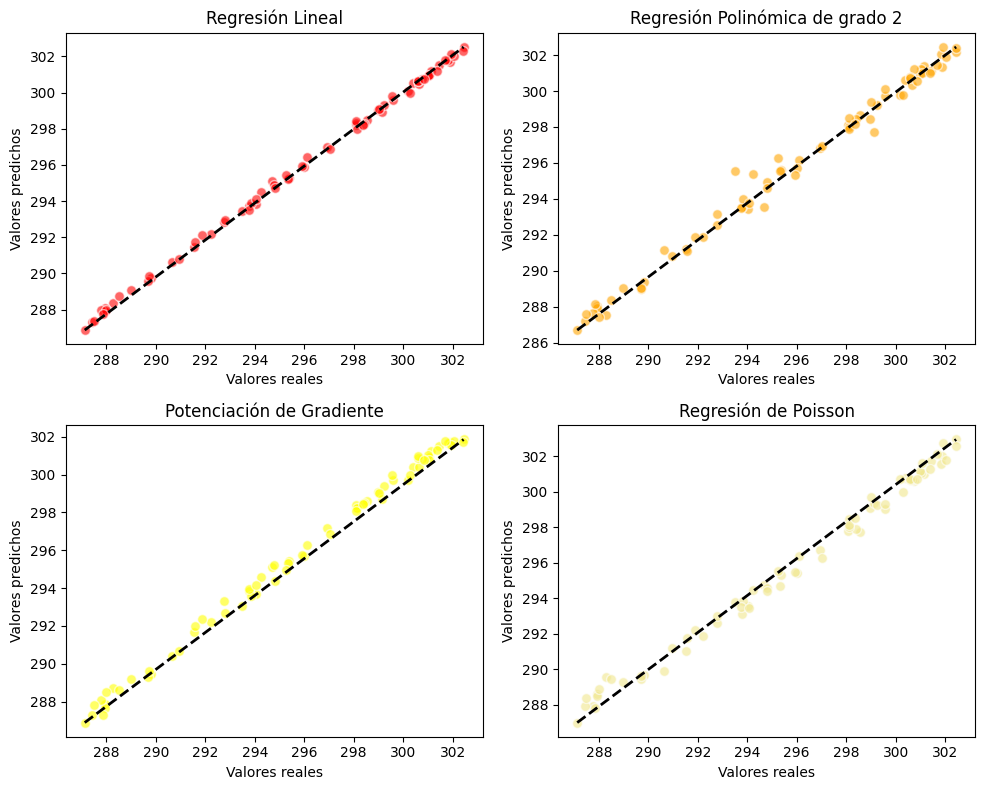

In [ ]:
grafica_precision(X_train_t, X_test_t, y_train_t, y_test_t, colores_temperature)

#### **Precisión del cálculo de la humedad**

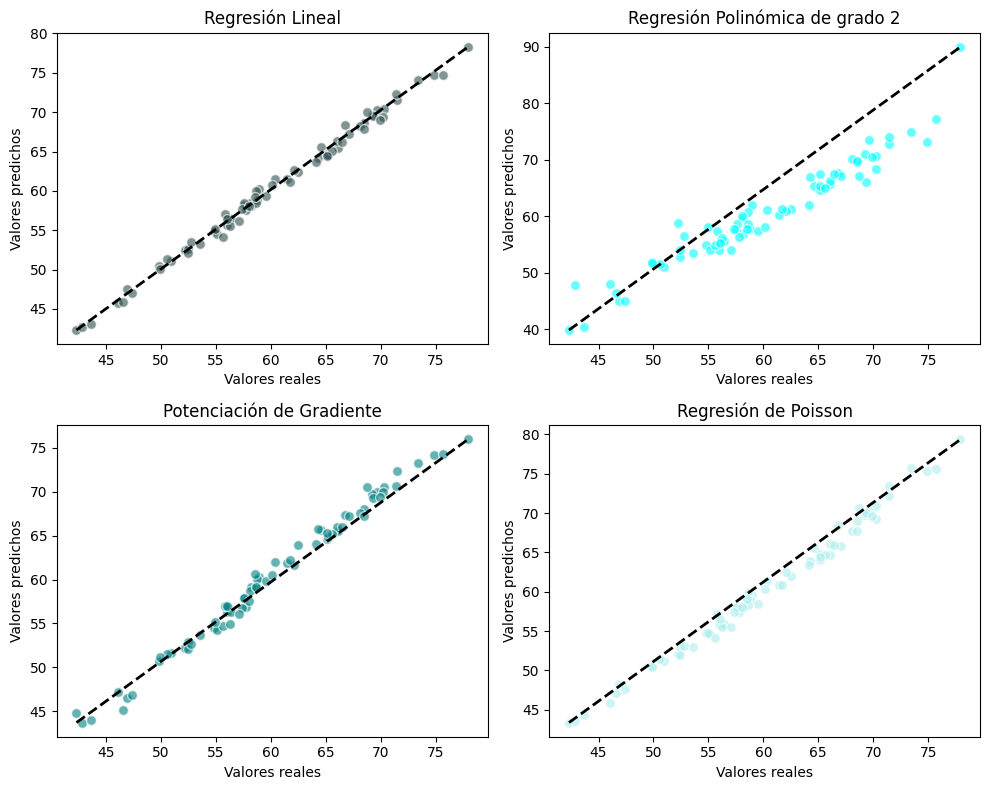

In [ ]:
grafica_precision(X_train_h, X_test_h, y_train_h, y_test_h, colores_humidity)

#### **Precisión del cálculo de la velocidad del viento**

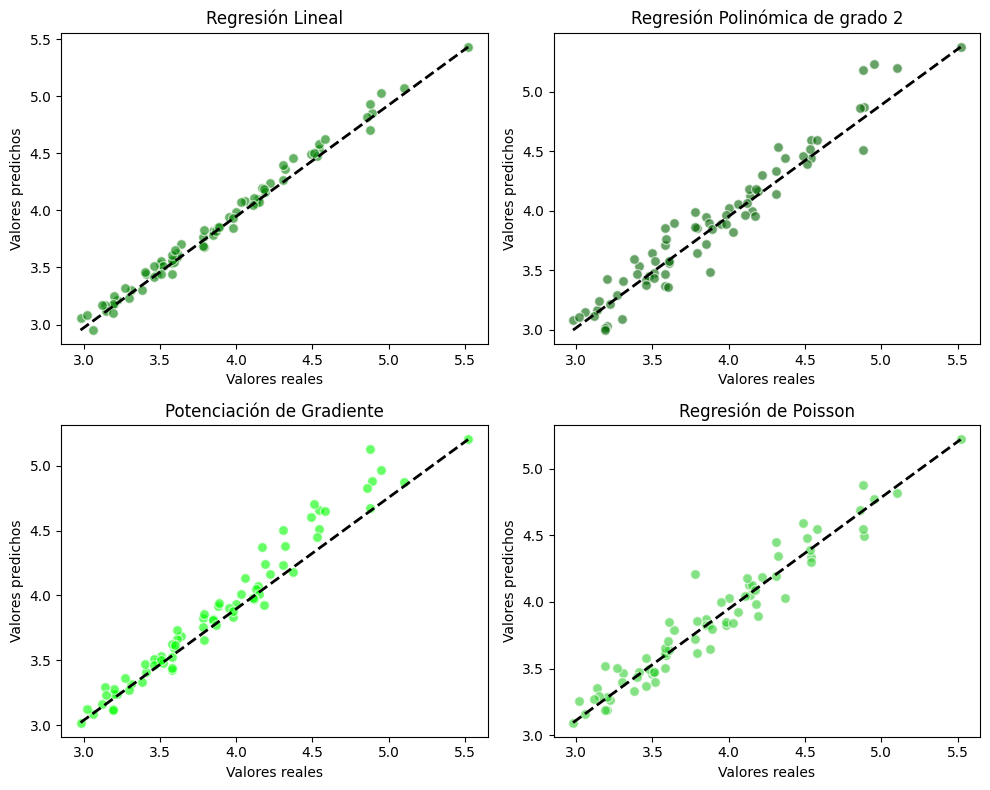

In [ ]:
grafica_precision(X_train_w, X_test_w, y_train_w, y_test_w, colores_wind)

### **Gráficas de los cálculos de residuos o errores**

#### **Residuos del cálculo de las precipitaciones**

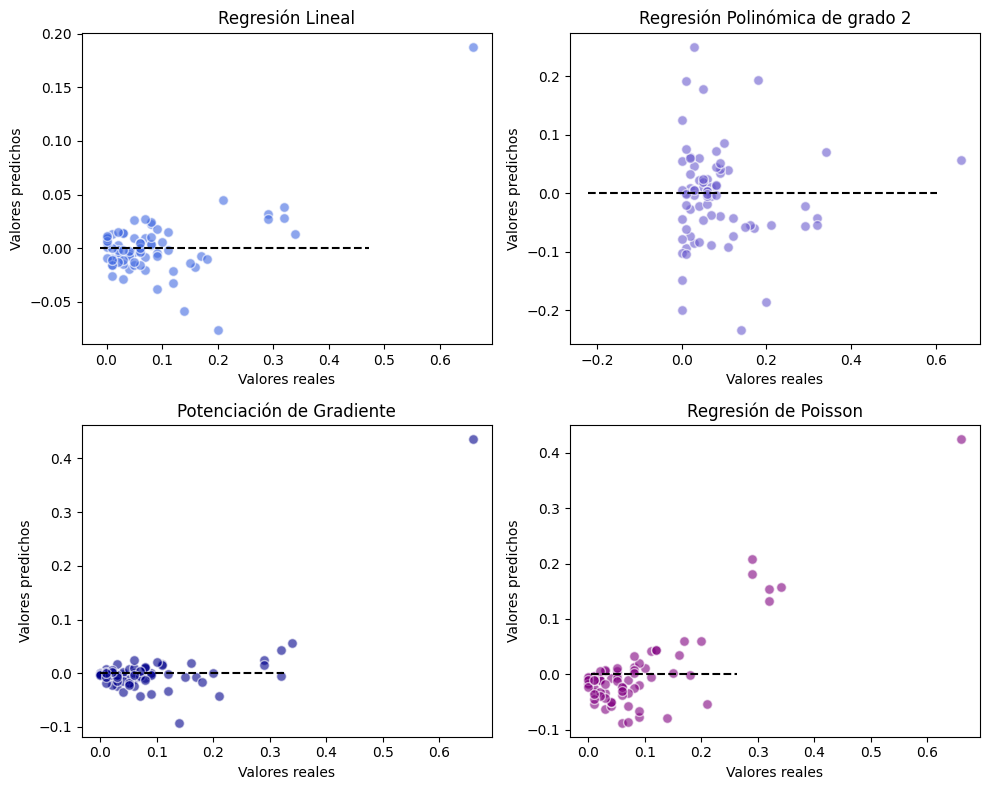

In [ ]:
grafica_residuos(X_train_p, X_test_p, y_train_p, y_test_p, colores_precipitation)

#### **Residuos del cálculo de las temperaturas**

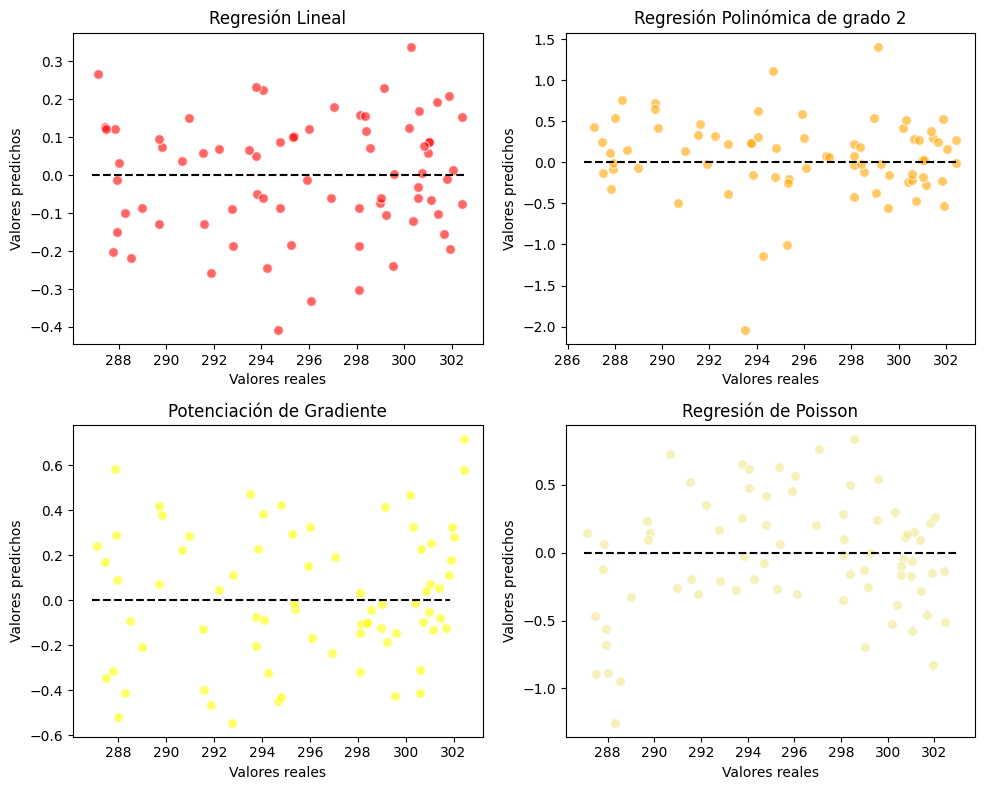

In [ ]:
grafica_residuos(X_train_t, X_test_t, y_train_t, y_test_t, colores_temperature)

#### **Residuos del cálculo de la humedad**

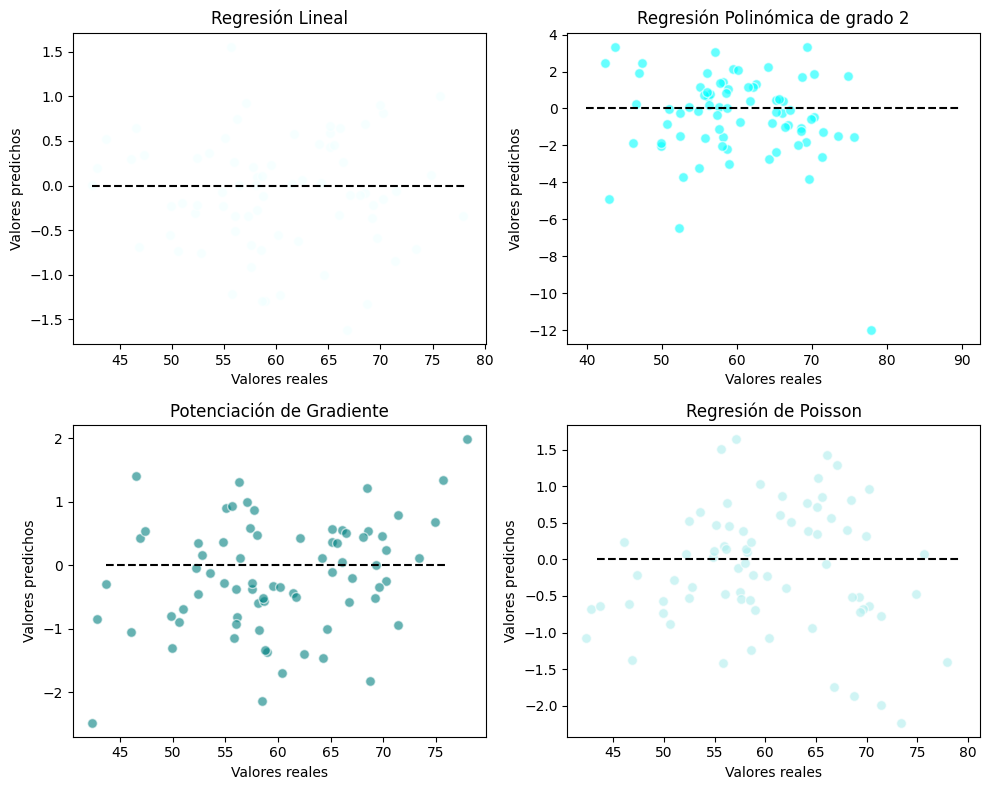

In [ ]:
grafica_residuos(X_train_h, X_test_h, y_train_h, y_test_h, colores_humidity)

#### **Residuos del cálculo de la velocidad del viento**

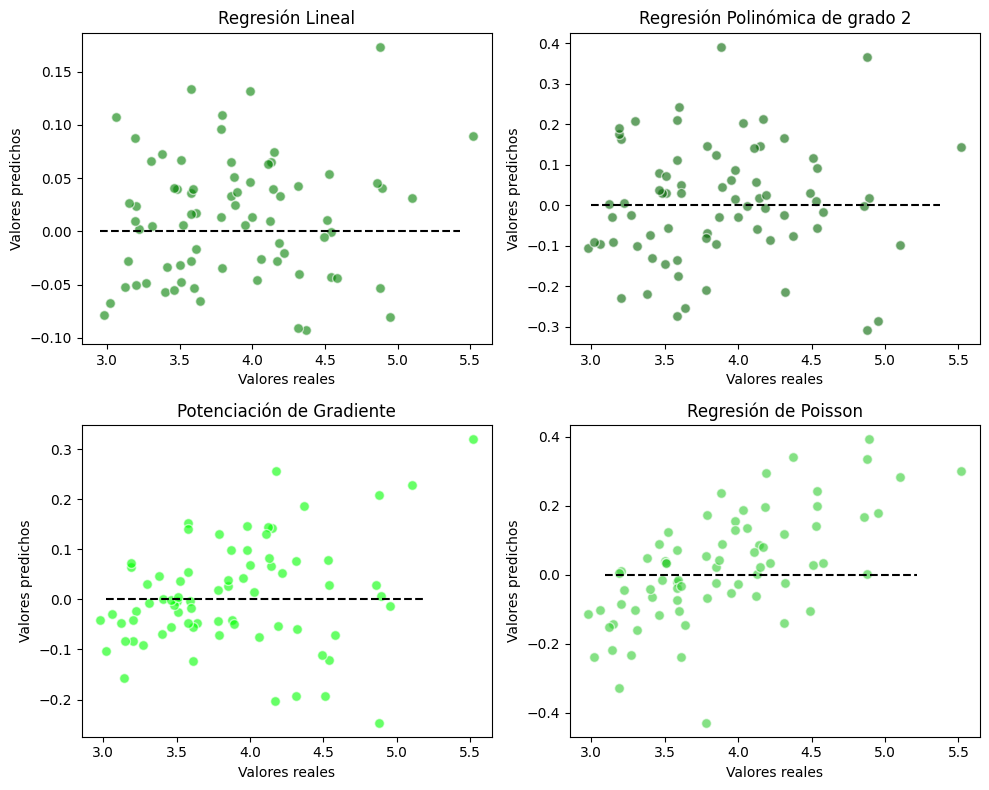

In [ ]:
grafica_residuos(X_train_w, X_test_w, y_train_w, y_test_w, colores_wind)

#### **Conclusión**

Lo que se puede obtener de esto es que, todas las variables de interés tienen un grado de precisión, menor pérdida y menor residuo con la regresión lineal, sin embargo, al observar las diversas gráficas de precipitaciones se debe observar que hay ciertos momentos donde todos los modelos menos el de la regresión de Poisson, se obtienen precipitaciones negativas, esto es imposible ya que no existe medidas imaginarias de precipitaciones, es decir no puede haber -1mm de precipitaciones. Por lo que finalmente se escogerá la regresión lineal para la predicción de las variables de temperatura, viento y humedad, y la regresión de Poisson para la predicción de las precipitaciones.

# **Cuarta parte: Predicción de las condiciones climáticas futuras**

## **Creación del dataframe para predicciones del resto del año**

In [ ]:
from datetime import datetime, timedelta

Esta parte del código define que las fechas futuras de las cuales se realizarán las predicciones serán a partir de la fecha en la que me encuentro al momento de la ejecución del código, que es el 24/06/2024 hasta el 31/12/2024, es decir una predicción de las lluvias, temperatura, humedad y viento del resto del año.

In [ ]:
fechas_futuras = pd.date_range(start="2024-06-24", end="2024-12-31", freq="D")
df_futuro_2024 = pd.DataFrame({"date": fechas_futuras})
df_futuro_2024["month"] = df_futuro_2024["date"].dt.month
df_futuro_2024["day"] = df_futuro_2024["date"].dt.day

df_futuro_2024 = df_futuro_2024.merge(df_historicos, on=['month', 'day'], how='left')

X_proximo_año_p = df_futuro_2024[predict_precipitation]
X_proximo_año_t = df_futuro_2024[predict_temp]
X_proximo_año_h = df_futuro_2024[predict_humidity]
X_proximo_año_w = df_futuro_2024[predict_wind]

# En el hipotético casi de que si hbieran días festivos o falta de datos del pasado se rellenarán los valores nulos.
df_futuro_2024.fillna(method='ffill', inplace=True)
df_futuro_2024.fillna(method='bfill', inplace=True)

print(df_futuro_2024.head())
print(df_futuro_2024.tail())

        date  month  day  ...  clouds.p75  clouds.st_dev  clouds.num
0 2024-06-24      6   24  ...        92.0          40.67         288
1 2024-06-25      6   25  ...        92.0          42.27         288
2 2024-06-26      6   26  ...        92.0          42.74         288
3 2024-06-27      6   27  ...        92.0          41.14         288
4 2024-06-28      6   28  ...        92.0          41.26         288

[5 rows x 53 columns]
          date  month  day  ...  clouds.p75  clouds.st_dev  clouds.num
186 2024-12-27     12   27  ...        80.0          37.80         288
187 2024-12-28     12   28  ...        64.0          33.50         288
188 2024-12-29     12   29  ...        68.0          39.01         288
189 2024-12-30     12   30  ...        42.0          35.85         288
190 2024-12-31     12   31  ...        73.5          37.87         288

[5 rows x 53 columns]


## **Desarrollo de las predicciones con los modelos elegidos**

En este caso se decidió hacer las predicciones con ***regresión lineal***, a excepción de la predicción de las precipitaciones que se decidió hacer con la ***regresión de Poisson***.

In [ ]:
import numpy as np

# Entrenar el modelo y predecir con él
modelos["Regresión de Poisson"].fit(X_train_p, y_train_p)
predicciones_precipitaciones = modelos["Regresión de Poisson"].predict(X_proximo_año_p)
predicciones_precipitaciones = np.maximum(predicciones_precipitaciones, 0)

modelos["Regresión Lineal"].fit(X_train_t, y_train_t)
predicciones_temperatura = modelos["Regresión Lineal"].predict(X_proximo_año_t)

modelos["Regresión Lineal"].fit(X_train_h, y_train_h)
predicciones_humedad = modelos["Regresión Lineal"].predict(X_proximo_año_h)

modelos["Regresión Lineal"].fit(X_train_w, y_train_w)
predicciones_viento = modelos["Regresión Lineal"].predict(X_proximo_año_w)

df_futuro_2024["precipitation.prediction"] = predicciones_precipitaciones
df_futuro_2024["temp.prediction"] = predicciones_temperatura
df_futuro_2024["humidity.prediction"] = predicciones_humedad
df_futuro_2024["wind.prediction"] = predicciones_viento

print(df_futuro_2024.head())
print(df_futuro_2024.tail())
print(df_futuro_2024["precipitation.prediction"].nsmallest(30))



        date  month  day  ...  temp.prediction  humidity.prediction  \
0 2024-06-24      6   24  ...       287.589411            67.893776   
1 2024-06-25      6   25  ...       286.864547            67.805421   
2 2024-06-26      6   26  ...       286.597536            69.279685   
3 2024-06-27      6   27  ...       286.099112            68.557032   
4 2024-06-28      6   28  ...       286.337835            66.788765   

   wind.prediction  
0         3.050314  
1         4.462669  
2         4.002765  
3         3.664670  
4         3.624387  

[5 rows x 57 columns]
          date  month  day  ...  temp.prediction  humidity.prediction  \
186 2024-12-27     12   27  ...       301.672890            51.282790   
187 2024-12-28     12   28  ...       301.532014            58.476495   
188 2024-12-29     12   29  ...       300.287994            63.332869   
189 2024-12-30     12   30  ...       302.266367            55.142991   
190 2024-12-31     12   31  ...       302.031563           

## **Gráficas de las predicciones realizadas para el resto del año**

### **Gráfica de las precipitaciones**

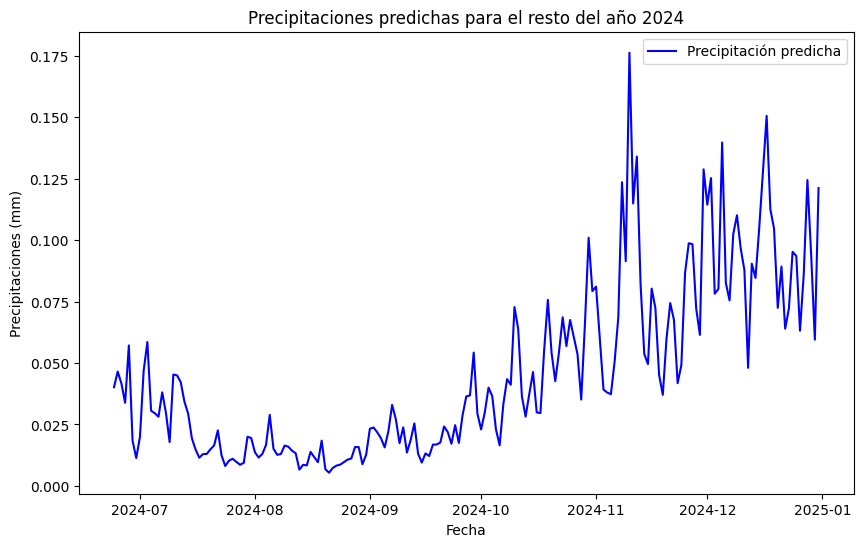

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_futuro_2024['date'], df_futuro_2024['precipitation.prediction'], label='Precipitación predicha', color='blue')
plt.xlabel('Fecha')
plt.ylabel('Precipitaciones (mm)')
plt.title('Precipitaciones predichas para el resto del año 2024')
plt.legend()
plt.show()

### **Gráfica de las temperaturas**

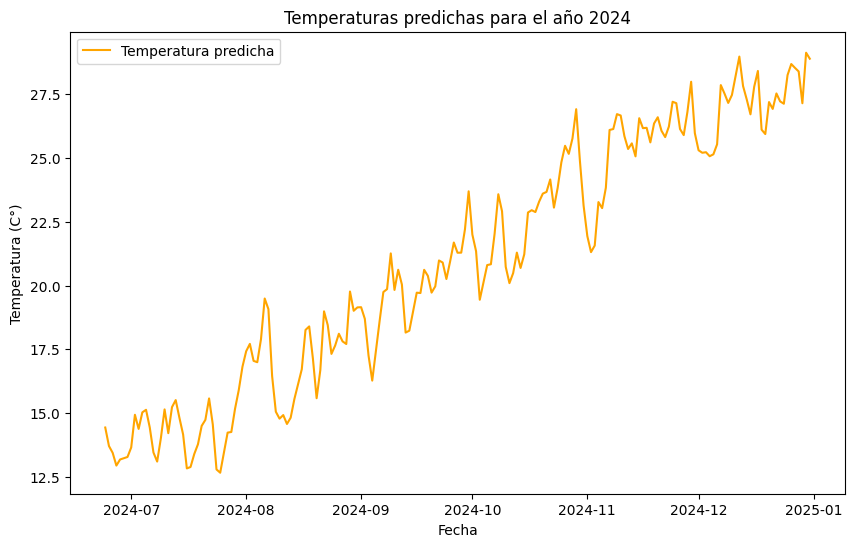

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_futuro_2024['date'], df_futuro_2024['temp.prediction'] - 273.15, label='Temperatura predicha', color='orange')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (C°)')
plt.title('Temperaturas predichas para el año 2024')
plt.legend()
plt.show()

### **Gráfica de la humedad**

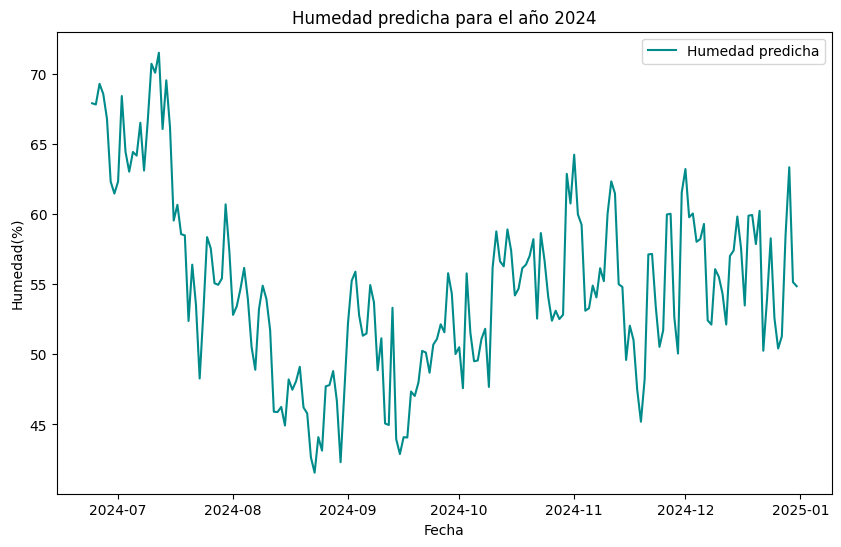

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_futuro_2024['date'], df_futuro_2024['humidity.prediction'], label='Humedad predicha', color='darkcyan')
plt.xlabel('Fecha')
plt.ylabel('Humedad(%)')
plt.title('Humedad predicha para el año 2024')
plt.legend()
plt.show()

### **Gráfica de la velocidad del viento**

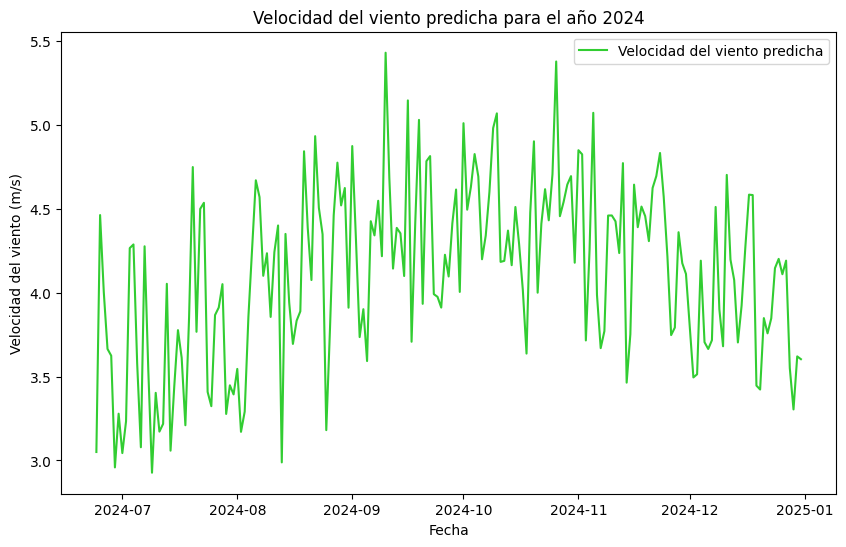

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_futuro_2024['date'], df_futuro_2024['wind.prediction'], label='Velocidad del viento predicha', color='limegreen')
plt.xlabel('Fecha')
plt.ylabel('Velocidad del viento (m/s)')
plt.title('Velocidad del viento predicha para el año 2024')
plt.legend()
plt.show()

## **Notas finales referidas a las predicciones**

Teniendo en cuenta la estacionalidad, las predicciones en general parecen estar correctas realizando comparaciones con los datos del pasado. Se muestra una congruencia mayor en la prediccion de las temperaturas y de la humedad, además las lluvias se mantienen en un rango aceptable al igual que el viento. Ahora con estos datos podemos ver si existe alguna anomalía en las predicciones para observar si hay algo de que preocuparse, además se puede observar y analizar las tendencias de las variables.

# **Quinta parte: Identificación de tendencias y anomalías**

Con la detección de tendencias y anomalías se pueden tomar mejores decisiones, ya que si por ejemplo vemos una baja o alza en la temperatura, o alza o baja en las precipitaciones, u alguna anomalía en alguna de ellas, podemos tomar mejores decisiones a la hora de por ejemplo realizar una plantación. Detectar los posibles cambios del entorno, así como las anomalías en determinados momentos pueden ser muy útiles para el lanzamiento de productos o nuevas dinámicas de servicios, o nuevas oportunidades de negocios.

## **Detección de tendencias**

Las tendencias son reveladoras fuentes de información que pueden mejorar la toma de decisiones. El análisis de los hallazgos e interpretaciones de las tendencias aportan un significativo valor a la planificación estratégica, a los planteamientos de las marcas y a la investigación dado que permite establecer rutas y patrones de investigación.

### **Definición de colores y la función para descomponer ploteos**

In [ ]:
import statsmodels.api as sm
colores_arr_p = np.array(colores_precipitation).reshape(-1)
colores_arr_t = np.array(colores_temperature).reshape(-1)
colores_arr_h = np.array(colores_humidity).reshape(-1)
colores_arr_w = np.array(colores_wind).reshape(-1)

Se reutilizaron los colores de los gráficos anteriores para los nuevos.

In [ ]:
def descomposicion_ploteos(resultado, subtitulo, colores):
  plt.figure(figsize=(10, 8))
  plt.suptitle(subtitulo)

  plt.subplot(411)
  plt.plot(resultado.observed, color=colores[0])
  plt.title('Observed')

  plt.subplot(412)
  plt.plot(resultado.trend, color=colores[1])
  plt.title('Trend')

  plt.subplot(413)
  plt.plot(resultado.seasonal, color=colores[2])
  plt.title('Seasonal')

  plt.subplot(414)
  plt.plot(resultado.resid, color=colores[3])
  plt.title('Residual')

  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.show()

Esta función sirve para que a la hora de sacar los resultados de las series temporales, descomponer el ploteo que realiza la propia librería estadística, y realizar un ploteo personalizado donde se le puede aplicar los colores deseados, ordenarlos a antojo, y modificar el tamaño de las figuras.

### **Gráficas de las tendencias**

Los gráficos de las tendencias, se dividen en cuatro partes:
* **Observed**: Las predicciones observadas, que son similares a los gráficos anteriores dodne se graficó las predicciones.
* **Trend**: La tendencia, que es para observar a medida que pasa el tiempo si aumenta o disminuye la variable.
* **Seasonal**:  Es la estacionalidad, el ciclo que se repite una y otra vez con el pasar de los días y meses.
* **Residual**: Los “residuales” en un modelo de series de tiempo son lo que queda después de ajustar un modelo. Para muchos (pero no todos) modelos de series de tiempo, los residuos son iguales a la diferencia entre las observaciones y los valores ajustados correspondientes.

#### **Gráfica de la tendencia de las precipitaciones**

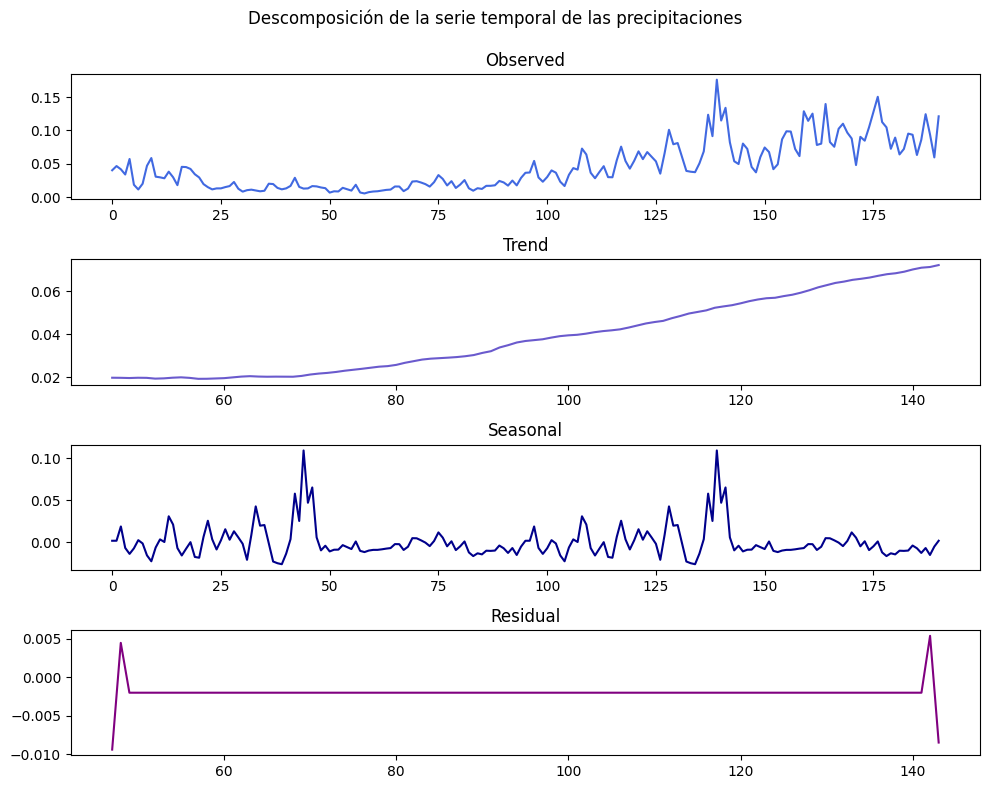

In [ ]:
# Descomponer la serie temporal de las precipitaciones
precipitation_series = df_futuro_2024["precipitation.prediction"]
result_precipitation = sm.tsa.seasonal_decompose(precipitation_series, model="additive", period=95)
# Graficar la descomposición de la serie temporal
descomposicion_ploteos(result_precipitation, "Descomposición de la serie temporal de las precipitaciones", colores_arr_p)

#### **Gráfica de la tendencia de las temperaturas**

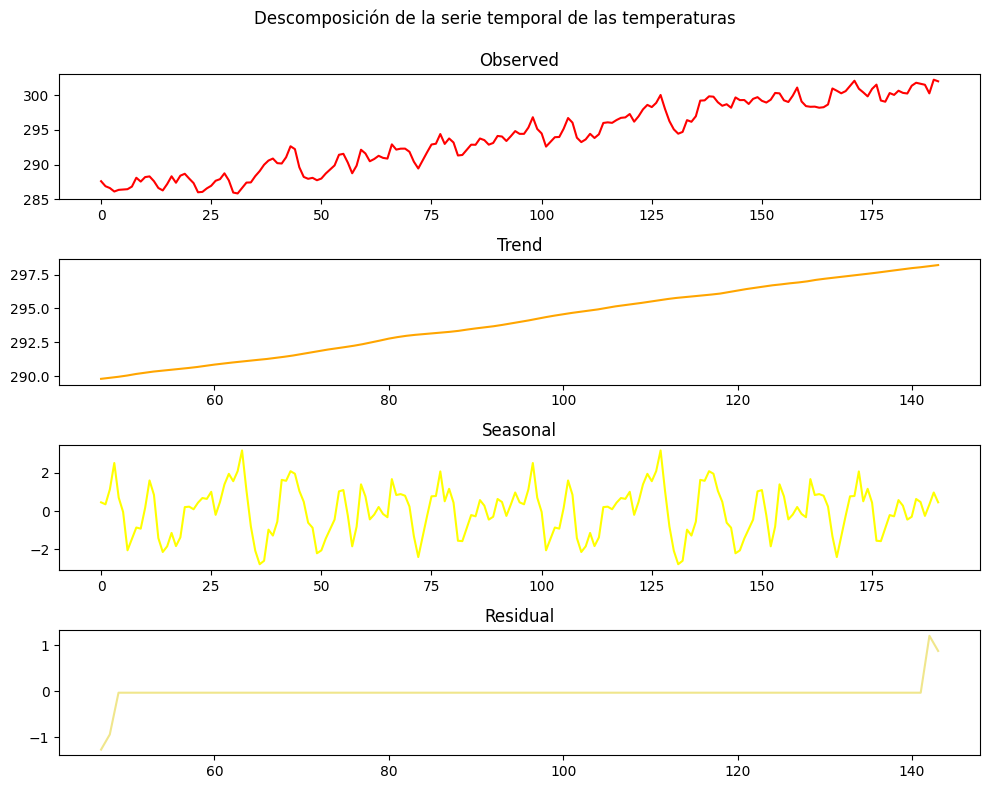

In [ ]:
# Descomponer la serie temporal de las temperaturas
temperature_series = df_futuro_2024["temp.prediction"]
result_temperature = sm.tsa.seasonal_decompose(temperature_series, model="additive", period=95)
# Graficar la descomposición de la serie temporal
descomposicion_ploteos(result_temperature, "Descomposición de la serie temporal de las temperaturas", colores_arr_t)

#### **Gráfica de la tendencia de la humedad**

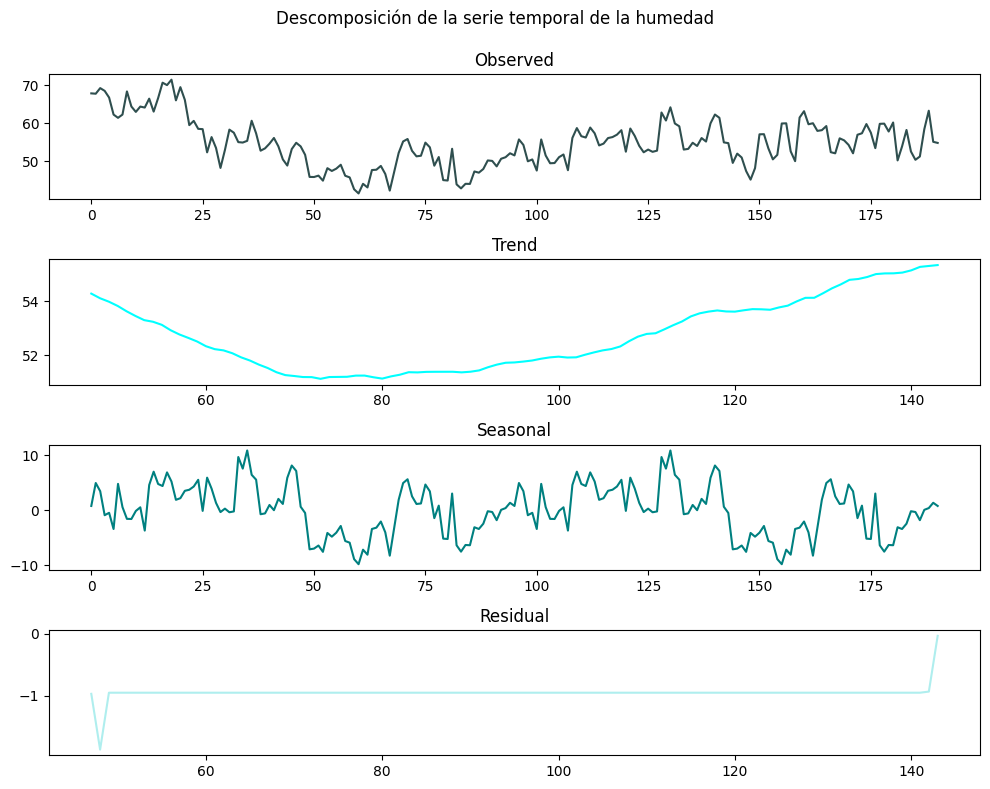

In [ ]:
# Descomponer la serie temporal de la humedad
humidity_series = df_futuro_2024["humidity.prediction"]
result_humidity = sm.tsa.seasonal_decompose(humidity_series, model="additive", period=95)
# Graficar la descomposición de la serie temporal
descomposicion_ploteos(result_humidity, "Descomposición de la serie temporal de la humedad", colores_arr_h)

#### **Gráfica de la tendencia de la velocidad del viento**

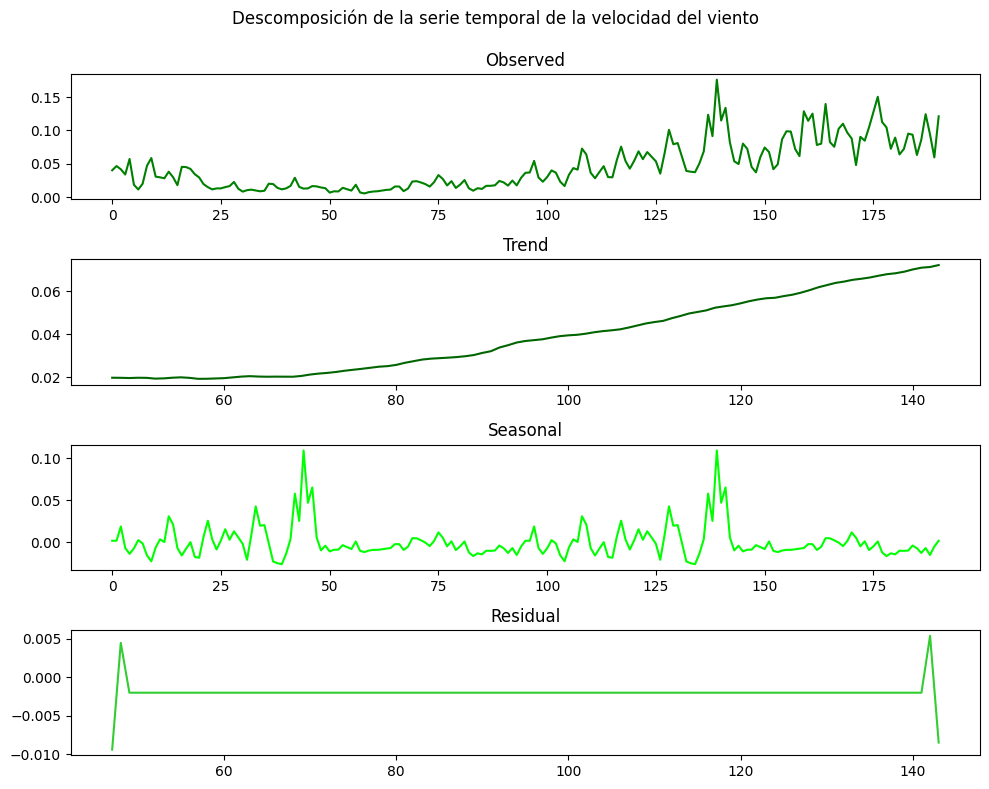

In [ ]:
# Descomponer la serie temporal de la velocidad del viento
wind_series = df_futuro_2024["wind.prediction"]
result_wind = sm.tsa.seasonal_decompose(wind_series, model="additive'", period=95)
# Graficar la descomposición de la serie temporal
descomposicion_ploteos(result_precipitation, "Descomposición de la serie temporal de la velocidad del viento", colores_arr_w)

## **Detección de anomalías**

Las anomalías hay varias formas de calcularlas. Las anomalías se pueden entender como un algo que se va de los límites que se consideran normales, partiendo de esto se puede calcular usando la desviación estándar, es decir cuando algo se va mucho más lejos de la desviación estándar se puede considerar una anomalía.

Otra forma de calcularlas mucho más precisa, puede ser con los modelos de clasificación, particularmente usando uno llamado Isolation Forest se puede calcular las anomalías de una manera mucho más precisa.

En los gráficos se podrán observar las anomalías como puntos o cruces en los picos por ejemplo.

La detección de anomalías sirve para detectar amenazas dependiendo del tipo de anomalía, es decir no es lo mismo una anomalía de velocidad del viento que una anomalía de temperatura. También se puede usar para detectar fallos de cálculo, si es que hay muchas anomalías.

### **Usando desviación estandar**

In [ ]:
def detect_anomalies(residual, threshold=2):
    #Detectar anomalías basadas en el residuo y un umbral de desviaciones estándar.

    mean_residual = np.mean(residual)
    std_residual = np.std(residual)
    anomalies = np.abs(residual - mean_residual) > threshold * std_residual
    return anomalies

# Detectar anomalías en los residuos de precipitaciones
precipitation_anomalies = detect_anomalies(result_precipitation.resid)
df_futuro_2024["precipitation.anomaly_stdev"] = precipitation_anomalies

# Detectar anomalías en los residuos de temperatura
temperature_anomalies = detect_anomalies(result_temperature.resid)
df_futuro_2024["temp.anomaly_stdev"] = temperature_anomalies

# Detectar anomalías en los residuos de humedad
humidity_anomalies = detect_anomalies(result_humidity.resid)
df_futuro_2024["humidity.anomaly_stdev"] = humidity_anomalies

# Detectar anomalías en los residuos de velocidad del viento
wind_anomalies = detect_anomalies(result_wind.resid)
df_futuro_2024["wind.anomaly_stdev"] = wind_anomalies

#### **Gráfica de las anomalías y la predicción de las precipitaciones**

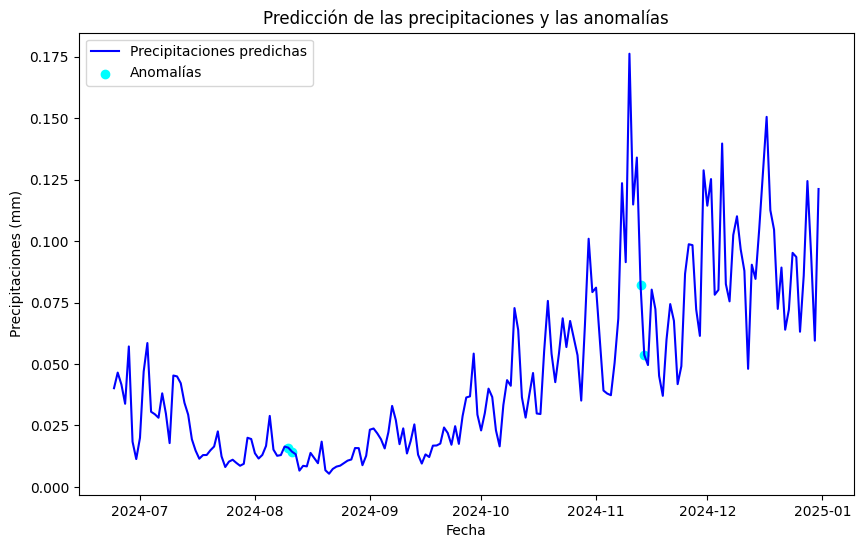

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_futuro_2024["date"], df_futuro_2024["precipitation.prediction"], label="Precipitaciones predichas", color="blue")
plt.scatter(df_futuro_2024["date"][precipitation_anomalies], df_futuro_2024["precipitation.prediction"][precipitation_anomalies], color="cyan", label="Anomalías")
plt.xlabel("Fecha")
plt.ylabel("Precipitaciones (mm)")
plt.title("Predicción de las precipitaciones y las anomalías")
plt.legend()
plt.show()

#### **Gráfica de las anomalías y la predicción de las temperaturas**

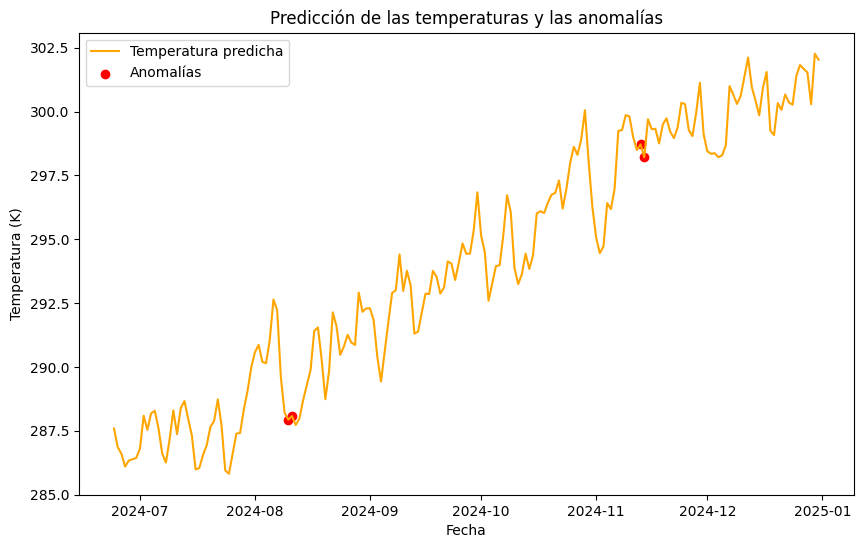

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_futuro_2024["date"], df_futuro_2024["temp.prediction"], label="Temperatura predicha", color="orange")
plt.scatter(df_futuro_2024["date"][temperature_anomalies], df_futuro_2024["temp.prediction"][temperature_anomalies], color="red", label="Anomalías")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (K)")
plt.title("Predicción de las temperaturas y las anomalías")
plt.legend()
plt.show()

#### **Gráfica de las anomalías y la predicción de la humedad**

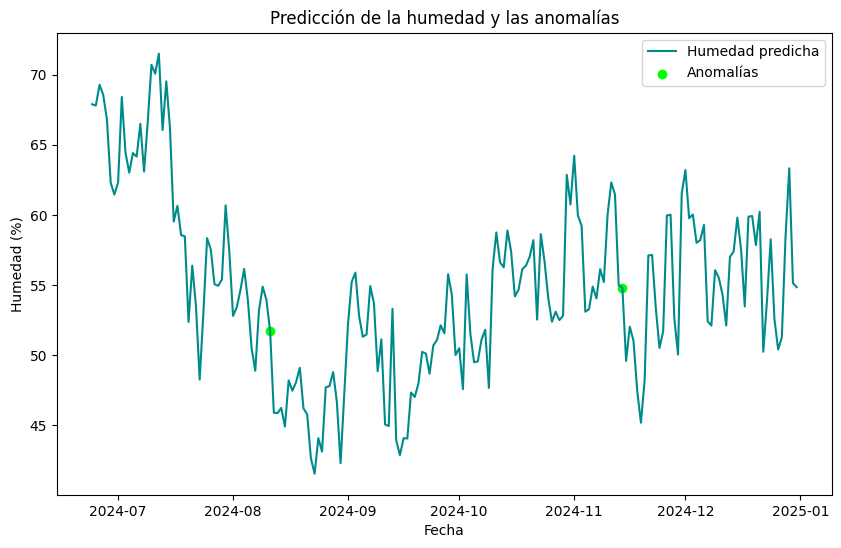

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_futuro_2024["date"], df_futuro_2024["humidity.prediction"], label="Humedad predicha", color="darkcyan")
plt.scatter(df_futuro_2024["date"][humidity_anomalies], df_futuro_2024["humidity.prediction"][humidity_anomalies], color="lime", label="Anomalías")
plt.xlabel("Fecha")
plt.ylabel("Humedad (%)")
plt.title("Predicción de la humedad y las anomalías")
plt.legend()
plt.show()

#### **Gráfica de las anomalías y la predicción de la velocidad del viento**

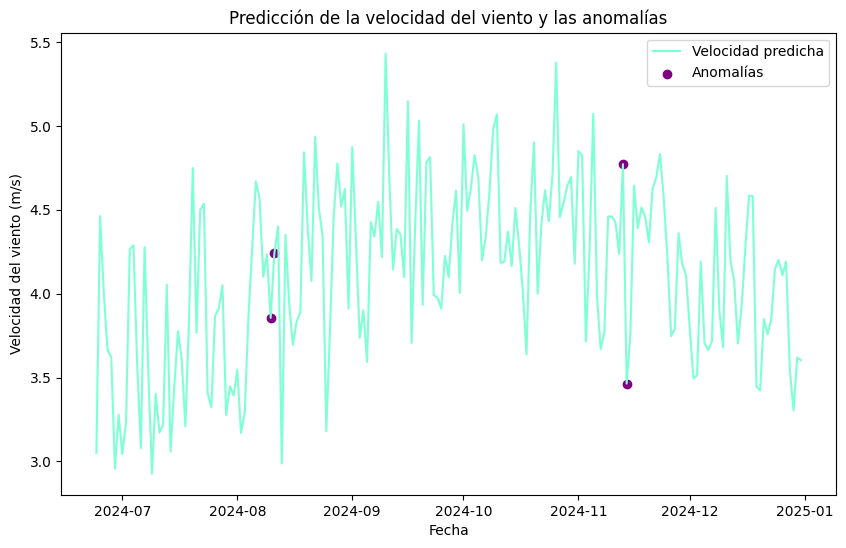

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_futuro_2024["date"], df_futuro_2024["wind.prediction"], label="Velocidad predicha", color="aquamarine")
plt.scatter(df_futuro_2024["date"][wind_anomalies], df_futuro_2024["wind.prediction"][wind_anomalies], color="purple", label="Anomalías")
plt.xlabel("Fecha")
plt.ylabel("Velocidad del viento (m/s)")
plt.title("Predicción de la velocidad del viento y las anomalías")
plt.legend()
plt.show()

### **Usando Isolation Forest**

In [ ]:
from sklearn.ensemble import IsolationForest
# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

# Entrenamiento del modelo
model_iforest = IsolationForest(n_estimators = 1000, random_state=42, contamination=0.01)
df_futuro_2024["anomaly"] = model_iforest.fit_predict(df_futuro_2024[["temp.prediction", "precipitation.prediction", "humidity.prediction", "wind.prediction"]])

# Las anomalías son marcadas como -1 por el Isolation Forest
anomalies = df_futuro_2024[df_futuro_2024["anomaly"] == -1]

#### **Gráfica de las anomalías y la predicción de las precipitaciones**

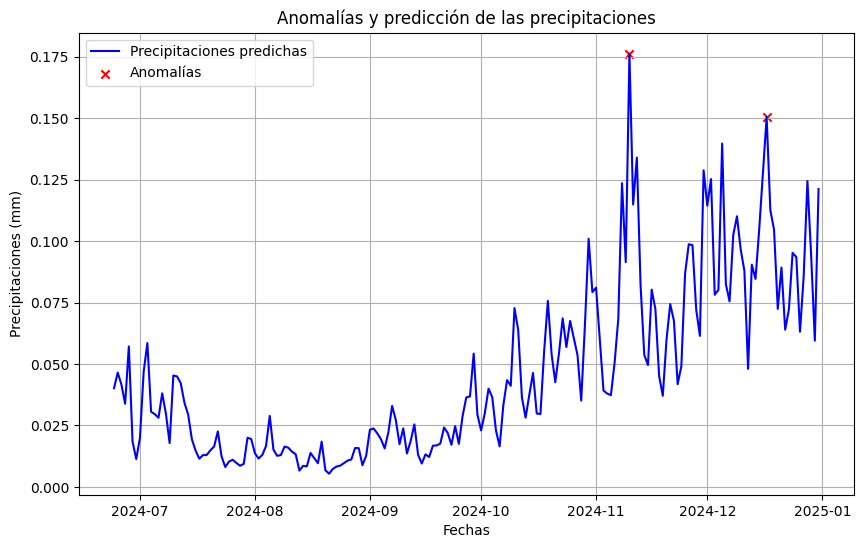

In [ ]:
# Precipitaciones
plt.figure(figsize=(10, 6))
plt.plot(df_futuro_2024["date"], df_futuro_2024["precipitation.prediction"], label="Precipitaciones predichas", color="blue")
plt.scatter(anomalies["date"], anomalies["precipitation.prediction"], color="red", label="Anomalías", marker="x")
plt.title("Anomalías y predicción de las precipitaciones")
plt.ylabel("Precipitaciones (mm)")
plt.xlabel("Fechas")
plt.legend()
plt.grid(True)
plt.show()

#### **Gráfica de las anomalías y la predicción de las temperaturas**

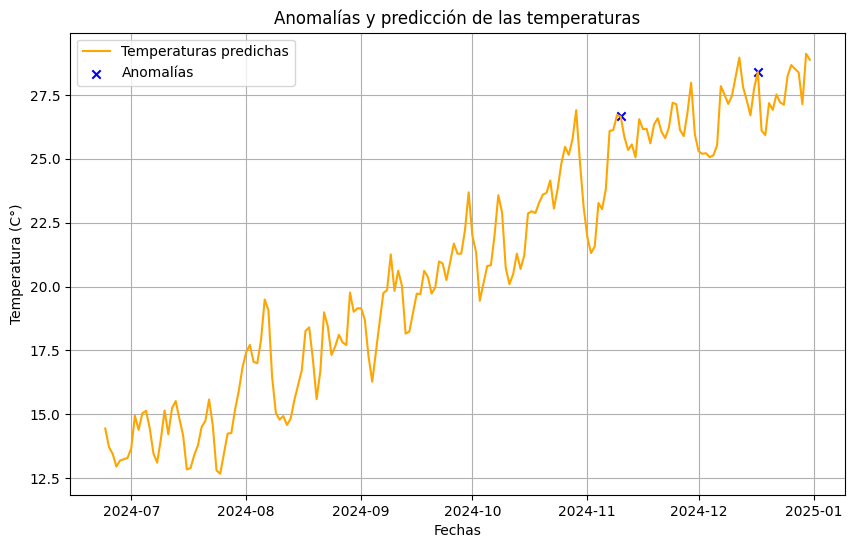

In [ ]:
# Temperatura
plt.figure(figsize=(10, 6))
plt.plot(df_futuro_2024["date"], df_futuro_2024["temp.prediction"] - 273.15, label="Temperaturas predichas", color="orange")
plt.scatter(anomalies["date"], anomalies["temp.prediction"] - 273.15, color="blue", label="Anomalías", marker="x")
plt.title("Anomalías y predicción de las temperaturas")
plt.ylabel("Temperatura (C°)")
plt.xlabel("Fechas")
plt.legend()
plt.grid(True)
plt.show()

#### **Gráfica de las anomalías y la predicción de la humedad**

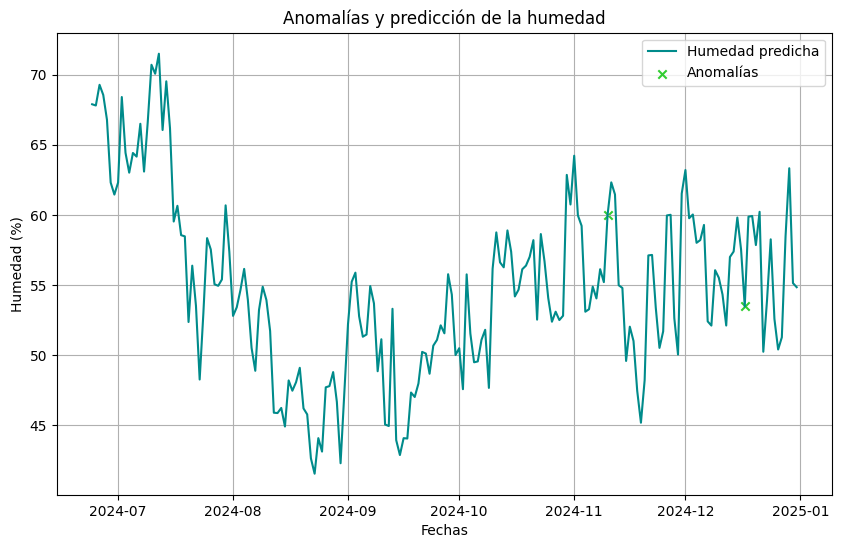

In [ ]:
# Humedad
plt.figure(figsize=(10, 6))
plt.plot(df_futuro_2024["date"], df_futuro_2024["humidity.prediction"], label="Humedad predicha", color="darkcyan")
plt.scatter(anomalies["date"], anomalies["humidity.prediction"], color="limegreen", label="Anomalías", marker="x")
plt.title("Anomalías y predicción de la humedad")
plt.ylabel("Humedad (%)")
plt.xlabel("Fechas")
plt.legend()
plt.grid(True)
plt.show()

#### **Gráfica de las anomalías y la predicción de la velocidad del viento**

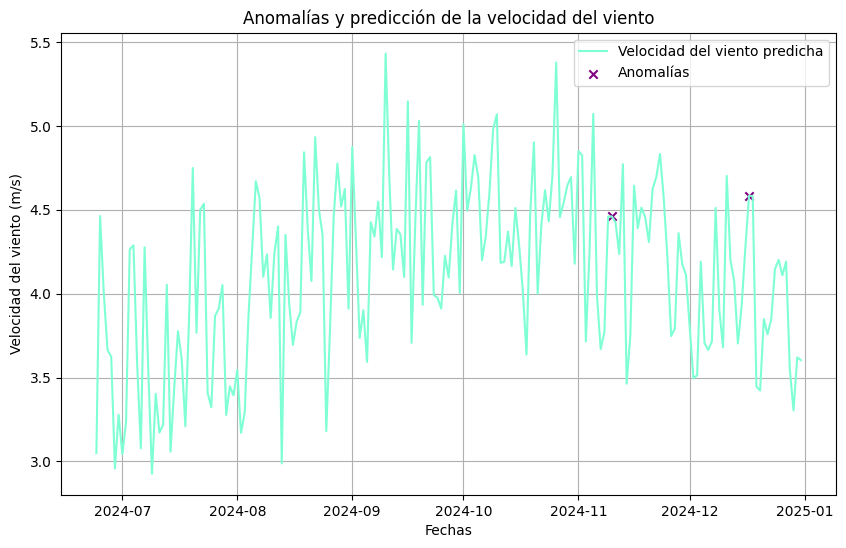

In [ ]:
# Viento
plt.figure(figsize=(10, 6))
plt.plot(df_futuro_2024["date"], df_futuro_2024["wind.prediction"], label="Velocidad del viento predicha", color="aquamarine")
plt.scatter(anomalies["date"], anomalies["wind.prediction"], color="purple", label="Anomalías", marker="x")
plt.title("Anomalías y predicción de la velocidad del viento")
plt.ylabel("Velocidad del viento (m/s)")
plt.xlabel("Fechas")
plt.legend()
plt.grid(True)
plt.show()

# **Conclusión**

En este proyecto, se demostró que el uso de técnicas de machine learning, como modelos de regresión, puede ser una herramienta poderosa para predecir variables climáticas clave en Santiago del Estero. La detección de anomalías, la identificación de tendencias y la validación de predicciones con datos históricos son aspectos fundamentales para tomar decisiones informadas en diversos sectores, desde la agricultura hasta la planificación urbana. Este estudio resalta la importancia de la ciencia de datos aplicada al clima y su potencial para mejorar la resiliencia y la adaptación frente a los desafíos climáticos.